In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0,'..')
import matplotlib.pyplot as plt
import os.path
import time
from geopy.extra.rate_limiter import RateLimiter
from geopy.geocoders import Nominatim
import acquire_sso, prepare_sso
import prepare
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

plt.rc('figure', figsize=(16,10))
plt.rc('font', size=14)
pd.set_option('display.max_colwidth', 250)
pd.set_option('display.max_columns', 50)

In [2]:
if os.path.isfile('sso_dict.csv'):
    df_dict = pd.read_csv('sso_dict.csv')
else:
    url_sso_dict = '''https://storage.googleapis.com/sa_saws_data/SAWS_SSO_DataFieldDescription_MM.xlsx'''
    df_dict = pd.read_excel(url_sso_dict)
    df_dict.to_csv('sso_dict.csv', index=False)

In [3]:
df_dict

,Field,Data Description
0,SSO_ID,Internal ID
1,INSPKEY,Not Used
2,SERVNO,Service Req # (internal use only)
3,REPORTDATE,Date Reported
4,SPILL_ADDRESS,Street number of spill
5,SPILL_ST_NAME,Streen name of spill
6,TOTAL_GAL,Total gallons spilled
7,GALSRET,Gallons returned to collection system
8,GAL,Disregard
9,SPILL_START,When SAWS received information about the spill or arrived at the location


In [4]:
# df = acquire_sso.acquire_sso()

In [5]:
# df.head(1)

In [6]:
# df = prepare_sso.prepare_sso_df()
# df.head(1)

In [7]:
# df = prepare.prepare_sso_df()
# print(df.shape[0])
# df.head(1)

In [8]:
# df.columns = ['sso_id','report_date','spill_address_num','spill_st_name',
#  'total_gal','gals_ret','spill_start','spill_stop','hrs','cause',
#  'comments','actions','watershed','unit_id','unit_id2','discharge_to',
#  'discharge_route','council_district','month','year','week',
#  'earz_zone','pipe_diam','pipe_len','pipe_type','inst_year','inches_no',
#  'rainfall_last3','spill_address_full','num_spills_recorded',
#  'num_spills_24mos','prevspill_24mos','unit_type','asset_type',
#  'last_cleaned','response_time','response_dttm','public_notice',
#  'root_cause','hrs_2','gal_2','hrs_3','gal_3','days_since_cleaned']

In [9]:
# df.head(1)

In [10]:
# df.ResponseTime * 60

In [11]:
# df.shape

In [12]:
# df_dict.shape

In [13]:
# df_dict['Data Description'].value_counts()

In [14]:
# unused = ['Disregard','Ignore','Service Req # (internal use only)',
#           'Not Used','Old mapping system reference (internal only)']
# df_dict[df_dict['Data Description'].isin(unused)]

In [15]:
# ready1_dict = df_dict[~df_dict['Data Description'].isin(unused)]
# print(len(ready1_dict))
# ready1_dict

In [16]:
# null_fields = ['SPILL_START_2','SPILL_START_3',
#                'SPILL_STOP_2','SPILL_STOP_3']
# final_dict = ready1_dict[~ready1_dict.Field.isin(null_fields)]\
#                     .reset_index(drop=True)
# len(final_dict)

In [17]:
# final_dict

In [18]:
# features_to_use = list(final_dict.Field)
# len(features_to_use)

In [19]:
# bad_features = list(df.columns[~df.columns.isin(features_to_use)])

In [20]:
# df = df.drop(columns=bad_features)
# df = df.drop(columns = ['TIMEINT','STEPS_TO_PREVENT'])
# df.shape

In [21]:
# string_features = ['SSO_ID','SPILL_ADDRESS','COUNCIL_DISTRICT',]
# for col in string_features:
#     df[col] = df[col].astype(str)
    
# time_features = ['REPORTDATE','SPILL_START','SPILL_STOP',
#                  'ResponseDTTM', 'LASTCLND']
# for col in time_features:
#     df[col] = pd.to_datetime(df[col])
    
# fill_features = ['NUM_SPILLS_24MOS','PREVSPILL_24MOS','HRS_2',
#                 'HRS_3','GAL_2','GAL_3']
# for col in fill_features:
#     df[col] = df[col].fillna(0)
    
# df.Root_Cause = df.Root_Cause.str.strip()

In [22]:
# df['days_since_cleaned'] = (df.SPILL_START - df.LASTCLND).dt.days

In [23]:
# df['country_address'] = df.spill_address_full + \
#                                   ',SAN ANTONIO,Texas,USA'
# df.country_address

In [24]:
# df[['country_address']].head(25)

In [25]:
# for i in range(df.index.max()//5):
#     print([1*i+5, 2*i+5, 3*i + 5])

In [26]:
# lmo = pd.DataFrame()
# lmo['loc'] = ['string','fnish']
# lmo['was'] = [2,3]
# lmo.was[1] = 4
# lmo

In [27]:
# locator = Nominatim(user_agent="myGeocoder")
# geocode = RateLimiter(locator.geocode, min_delay_seconds=.1)
# test2 = pd.Series()

# counter = 10
# for i in range(0, df.index.max(), 10):
#     test = df[['country_address']][i:counter]
#     test['location'] = test['country_address'].apply(geocode)
#     test['zip_code'] = 'None'
#     for t,l in enumerate(test.location):
#         if l is not None:
#             test['zip_code'][counter+t-10] = l.raw['display_name']\
#                                     .split(',')[-2]
#     time.sleep(2)
#     test2 = test2.append(test.zip_code)
#     counter+=10
# test2

### Working

In [28]:
# locator = Nominatim(user_agent="myGeocoder")
# geocode = RateLimiter(locator.geocode, min_delay_seconds=.1, 
#                      max_retries=10, error_wait_seconds=1)
# df['location'] = df['country_address'].apply(geocode)
# df['zip_code'] = 'None'

In [29]:
# for t,l in enumerate(df.location):
#         if l is not None:
#             df['zip_code'][t] = l.raw['display_name']\
#                                     .split(',')[-2]

In [30]:
df = prepare.prepare_sso_with_zipcodes()
print(df.shape[0])
df.head(1)

3183


,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,inst_year,inches_no,rainfall_last3,spill_address_full,num_spills_recorded,num_spills_24mos,prevspill_24mos,unit_type,asset_type,last_cleaned,response_time,response_dttm,public_notice,root_cause,hrs_2,gal_2,hrs_3,gal_3,days_since_cleaned,total_gal_binned,country_address,location,zip_code
0,6582,2019-03-10,3200,THOUSAND OAKS DR,2100,2100.0,2019-03-10 13:16:00,2019-03-10 14:40:00,1.4,Grease,"Spill ContainedReturned to SystemArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,",CLEANED MAIN,SALADO CREEK,66918,66917,STREET,None,NaN,3,2019,11,0.0,8.0,16.55,PVC,1997.0,NaN,NaN,3200 THOUSAND OAKS DR,1,1.0,0,GRAVITY,Sewer Main,NaN,27.0,2019-03-10 13:43:00,False,NaN,0.0,0.0,0.0,0.0,NaN,"(1000, 5000]","3200 THOUSAND OAKS DR,SAN ANTONIO,Texas,USA","3200, Thousand Oaks Drive, Horseshoe Bend, Lost Creek, Austin, Travis County, Texas, 78746, United States of America",78746


In [31]:
df.zip_code.value_counts().head(5)

None      945
 Texas    288
 78228    124
 78223    108
 78209     93
Name: zip_code, dtype: int64

In [32]:
# df.zip_code = df.zip_code.str.strip()
# df = df[(df.zip_code != 'None') & (df.zip_code != 'Texas')]
# df.shape

In [33]:
df.isna().sum()

sso_id                    0
report_date               0
spill_address_num         0
spill_st_name             0
total_gal                 0
gals_ret                475
spill_start               0
spill_stop                0
hrs                       3
cause                     0
comments                533
actions                   8
watershed                 0
unit_id                   4
unit_id2                244
discharge_to              4
discharge_route         827
council_district        322
month                     0
year                      0
week                      0
earz_zone              1318
pipe_diam               190
pipe_len                190
pipe_type               190
inst_year               118
inches_no               487
rainfall_last3          542
spill_address_full       43
num_spills_recorded       0
num_spills_24mos          0
prevspill_24mos           0
unit_type                17
asset_type                2
last_cleaned           2082
response_time       

In [34]:
df.spill_address_full.head(15)

0     3200 THOUSAND OAKS DR
1             6804 S FLORES
2       215 Audrey Alene Dr
3       3602 SE MILITARY DR
4              100 PANSY LN
5       3200 S Hackberry St
6         9910 Sugarloaf Dr
7         3507 Piedmont Ave
8                349 Alicia
9      1502 W Mistletoe Ave
10           5 Trophy Ridge
11          4100 Culebra Rd
12      25903 TURQUOISE SKY
13         116 Golden Crown
14    THOUSAND OAKS DR 3023
Name: spill_address_full, dtype: object

In [35]:
df.days_since_cleaned.dropna()

965     227.0
966     571.0
968     555.0
969     560.0
972     325.0
        ...  
3059     13.0
3075     22.0
3076     16.0
3101     13.0
3106      8.0
Name: days_since_cleaned, Length: 1101, dtype: float64

In [36]:
df[df.days_since_cleaned == df.days_since_cleaned.max()]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,inst_year,inches_no,rainfall_last3,spill_address_full,num_spills_recorded,num_spills_24mos,prevspill_24mos,unit_type,asset_type,last_cleaned,response_time,response_dttm,public_notice,root_cause,hrs_2,gal_2,hrs_3,gal_3,days_since_cleaned,total_gal_binned,country_address,location,zip_code
1020,3555,2015-02-23,3,VILLA VERDE,200,0.0,2015-02-23 15:28:00,2015-02-23 16:46:00,1.3,Grease,"Spill ContainedArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,",CLEANED MAIN,DOS RIOS,6169,6157,DRAINAGE CULVERT,None,8.0,2,2015,9,0.0,8.0,400.0,VCP,1974.0,NaN,NaN,3 Villa Verde ( Over Edwards Aquifer Transition Zone ),1,1.0,0,GRAVITY,Sewer Main,2009-11-06 00:00:00,51.0,2015-02-23 16:19:00,False,grease,0.0,0.0,0.0,0.0,1935.0,"(50, 250]","3 Villa Verde ( Over Edwards Aquifer Transition Zone ),SAN ANTONIO,Texas,USA",NaN,None


In [37]:
features = df.isna().sum() / df.shape[0]
bad_list = features[features > .5]
print(len(bad_list))
bad_list

4


last_cleaned          0.654100
response_time         0.607603
response_dttm         0.607603
days_since_cleaned    0.654100
dtype: float64

In [38]:
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'f')))

,sso_id,spill_address_num,total_gal,gals_ret,hrs,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,inst_year,inches_no,rainfall_last3,num_spills_recorded,num_spills_24mos,response_time,hrs_2,gal_2,hrs_3,gal_3,days_since_cleaned
count,3183.000000,3183.000000,3183.000000,2708.000000,3180.000000,2861.000000,3183.000000,3183.000000,3183.000000,1865.000000,2993.000000,2993.000000,3065.000000,2696.000000,2641.000000,3183.000000,3183.000000,1249.000000,3183.000000,3183.000000,3183.000000,3183.000000,1101.000000
mean,3324.371662,4255.424442,33115.578071,3928.728582,4.323485,4.970290,6.201068,2012.904178,25.676406,0.247185,11.380722,288.262431,2019.119413,0.476495,0.517490,1.925856,0.734527,-221.930024,0.221306,3655.564562,0.022853,151.032045,266.709355
std,1883.181655,4660.968740,311114.890134,59048.789729,38.110123,3.048471,3.584717,2.945651,15.626943,1.020458,10.173888,465.354265,578.614360,1.309856,1.124533,2.084671,1.211286,9058.281841,2.714416,61246.087979,0.453691,4848.806471,304.310465
min,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2009.000000,1.000000,0.000000,0.000000,0.000000,1899.000000,0.000000,0.000000,1.000000,0.000000,-319950.000000,0.000000,0.000000,0.000000,0.000000,-2.000000
25%,2097.500000,700.000000,50.000000,0.000000,0.750000,2.000000,3.000000,2010.000000,12.000000,0.000000,8.000000,136.000000,1962.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,43.000000
50%,2908.000000,2507.000000,250.000000,0.000000,1.400000,5.000000,6.000000,2012.000000,24.000000,0.000000,8.000000,264.500000,1977.000000,0.000000,0.010000,1.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,164.000000
75%,5779.500000,6669.000000,2435.000000,0.000000,2.816667,8.000000,9.000000,2015.000000,40.000000,0.000000,8.000000,351.000000,1994.000000,0.100000,0.460000,2.000000,1.000000,54.000000,0.000000,0.000000,0.000000,0.000000,381.000000
max,6584.000000,29621.000000,13304550.000000,2385150.000000,1796.000000,10.000000,12.000000,2019.000000,53.000000,5.000000,66.000000,11689.350000,9999.000000,9.870000,12.270000,21.000000,13.000000,3020.000000,118.000000,2377350.000000,15.530000,255300.000000,1935.000000


In [39]:
len(df.report_date.unique())

1878

In [40]:
df[df.num_spills_recorded == df.num_spills_recorded.max()]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,inst_year,inches_no,rainfall_last3,spill_address_full,num_spills_recorded,num_spills_24mos,prevspill_24mos,unit_type,asset_type,last_cleaned,response_time,response_dttm,public_notice,root_cause,hrs_2,gal_2,hrs_3,gal_3,days_since_cleaned,total_gal_binned,country_address,location,zip_code
71,6512,2018-11-13,606,N ALAMO ST,2080,0.0,2018-11-13 08:16:00,2018-11-13 10:00:00,1.733333,Contractor,NaN,REMOVED BYPASS,DOS RIOS,STMDRAIN,NaN,STORMDRAIN - Then entered the San Antonio River,SAN ANTONIO RIVER,NaN,11,2018,46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ALAMO ST N 00606,21,0.0,0,NaN,Bypass,NaN,24.0,2018-11-13 08:40:00,False,contractor,0.0,0.0,0.0,0.0,NaN,"(1000, 5000]","ALAMO ST N 00606,SAN ANTONIO,Texas,USA",NaN,None
716,5863,2016-04-23,4006,BRIARGLEN,6000,NaN,2016-04-22 21:00:00,2016-04-22 23:00:00,2.000000,Other,NaN,REPAIRED PUMP,SALADO CREEK,46429,46423,CREEK BED - SPILLED INTO BEITEL CREEK,BEITEL CREEK,NaN,4,2016,17,0.0,NaN,NaN,NaN,NaN,0.0,0.5,BRIARGLEN 04006,21,0.0,0,GRAVITY,Sewer Main,NaN,0.0,2016-04-22 21:00:00,False,by pass pump leak,0.0,0.0,0.0,0.0,NaN,"(5000, 50000]","BRIARGLEN 04006,SAN ANTONIO,Texas,USA","Briarglen, San Antonio, Bexar County, Texas, 78218, United States of America",78218
800,5774,2015-12-22,5704,PRESA ST S,90,NaN,2015-12-21 11:16:00,2015-12-21 18:00:00,6.733333,Structural,"Repaired main, 10"" sewer main",REPAIRED MAIN,DOS RIOS,NaN,NaN,DRAINAGE CULVERT,NONE,3.0,12,2015,52,0.0,NaN,NaN,NaN,NaN,0.0,0.0,STORY LN 00105,21,0.0,0,NaN,NaN,NaN,404.0,2015-12-21 18:00:00,False,structural,0.0,0.0,0.0,0.0,NaN,"(50, 250]","STORY LN 00105,SAN ANTONIO,Texas,USA","Story Lane, San Antonio, Bexar County, Texas, 78223, United States of America",78223


In [41]:
df[df.total_gal.isin(list(df.total_gal.nlargest(8)))]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,inst_year,inches_no,rainfall_last3,spill_address_full,num_spills_recorded,num_spills_24mos,prevspill_24mos,unit_type,asset_type,last_cleaned,response_time,response_dttm,public_notice,root_cause,hrs_2,gal_2,hrs_3,gal_3,days_since_cleaned,total_gal_binned,country_address,location,zip_code
84,6499,2018-10-24,108,CHAPPIE JAMES WAY,2448400,0.0,2018-10-24 13:50:00,2018-10-28 13:29:00,95.65,I/I,NaN,MONITORED AREA,LEON CREEK,1210,42319,CREEK BED - Spilled Into Leon Creek,LEON CREEK,NaN,10,2018,43,0.0,54.0,1335.00,RCP,1965.0,0.79,0.49,CHAPPIE JAMES WAY 00108,10,9.0,2018-10-15 00:00:00,OUTFALL,Sewer Main,NaN,0.0,2018-10-24 13:50:00,True,rain event,0.0,0.0,0.0,0.0,NaN,"(2000000, 13304550]","CHAPPIE JAMES WAY 00108,SAN ANTONIO,Texas,USA","Chappie James Way, Bexar County, Texas, 78242, United States of America",78242
115,6466,2018-09-20,6606,SWISS OAKS,13304550,0.0,2018-09-20 09:45:00,2018-11-19 01:30:00,620.07,I/I,NaN,MONITORED AREA,LEON CREEK,903059,71380,CREEK BED - Spilled Into Leon Creek,LEON CREEK,6.0,9,2018,38,0.0,42.0,1301.00,RCP,1973.0,0.56,0.00,SWISS OAKS 06606,5,5.0,2018-09-10 00:00:00,OUTFALL,Sewer Main,NaN,0.0,2018-09-20 09:45:00,True,rain event,0.0,0.0,0.0,0.0,NaN,"(2000000, 13304550]","SWISS OAKS 06606,SAN ANTONIO,Texas,USA",NaN,None
646,5942,2016-06-02,700,HOLBROOK,6026731,0.0,2016-06-02 11:09:00,2016-06-06 07:30:00,92.35,I/I,NaN,DILUTED BY HEAVY RAINWATER,SALADO CREEK,47822,922726,CREEK BED - SPILLED INTO SALADO CREEK,SALADO CREEK,2.0,6,2016,23,0.0,0.0,5.89,,1973.0,2.34,2.73,HOLBROOK 00700 - Spilled Into Salado Creek,6,6.0,2016-05-30 00:00:00,OUTFALL,Sewer Main,NaN,0.0,2016-06-02 11:09:00,True,rain event,0.0,0.0,0.0,0.0,NaN,"(2000000, 13304550]","HOLBROOK 00700 - Spilled Into Salado Creek,SAN ANTONIO,Texas,USA",NaN,None
647,5943,2016-06-02,6606,SWISS OAKS,2050500,0.0,2016-06-02 11:45:00,2016-06-06 12:30:00,96.75,I/I,NaN,DILUTED BY HEAVY RAINWATER,LEON CREEK,903064,903061,CREEK BED - SPILLED INTO LEON CREEK,LEON CREEK,6.0,6,2016,23,0.0,0.0,16.81,,2014.0,2.34,2.73,6606 Swiss Oaks - Spilled Into Leon Creek,1,1.0,0,OUTFALL,Sewer Main,NaN,0.0,2016-06-02 11:45:00,True,rain event,0.0,0.0,0.0,0.0,NaN,"(2000000, 13304550]","6606 Swiss Oaks - Spilled Into Leon Creek,SAN ANTONIO,Texas,USA",NaN,None
653,5922,2016-05-31,108,CHAPPIE JAMES WAY,2453340,0.0,2016-05-31 17:08:00,2016-06-01 07:02:00,13.90,I/I,NaN,DILUTED BY HEAVY RAINWATER,LEON CREEK,1187,1074,CREEK BED - SPILLED INTO LEON CREEK,LEON CREEK,NaN,5,2016,23,0.0,54.0,17.61,CSC,1983.0,1.84,2.41,CHAPPIE JAMES WAY 00108,3,3.0,2016-05-16 00:00:00,SIPHON,Sewer Main,NaN,0.0,2016-05-31 17:08:00,True,rain event,118.0,2377350.0,0.0,0.0,NaN,"(2000000, 13304550]","CHAPPIE JAMES WAY 00108,SAN ANTONIO,Texas,USA","Chappie James Way, Bexar County, Texas, 78242, United States of America",78242
688,5888,2016-05-18,700,HOLBROOK,2754790,0.0,2016-05-17 18:28:00,2016-05-21 03:00:00,80.53,I/I,NaN,DILUTED BY HEAVY RAINWATER,SALADO CREEK,990827,48236,CREEK BED - Spilled Into Salado Creek,SALADO CREEK,2.0,5,2016,21,0.0,0.0,0.00,,2015.0,0.14,1.71,700 HOLBROOK,1,1.0,0,OUTFALL,Sewer Main,NaN,0.0,2016-05-17 18:28:00,True,rain event,0.0,0.0,0.0,0.0,NaN,"(2000000, 13304550]","700 HOLBROOK,SAN ANTONIO,Texas,USA","Holbrook, Palo Pinto County, Texas, United States of America",Texas
2338,18,2010-10-20,8600,MISSION PKWY,4442000,NaN,2010-10-20 09:00:00,2010-10-27 11:00:00,170.00,Break In Main,REPAIRED FORCE MAIN - L/S # 172,REPAIRED BROKEN MAIN,DOS RIOS,13440,14063,CREEK BED,SAN ANTONIO RIVER,3.0,10,2010,43,NaN,30.0,122.58,FRP,1990.0,0.00,0.00,MISSION PKWY 080/1,2,0.0,0,FORCE,Sewer Main,NaN,NaN,NaT,True,structural,0.0,0.0,0.0,0.0,NaN,"(2000000, 13304550]","MISSION PKWY 080/1,SAN ANTONIO,Texas,USA",NaN,None
2771,1796,2010-01-15,300,PETALUMA BLVD E,3570000,NaN,2010-01-15 02:

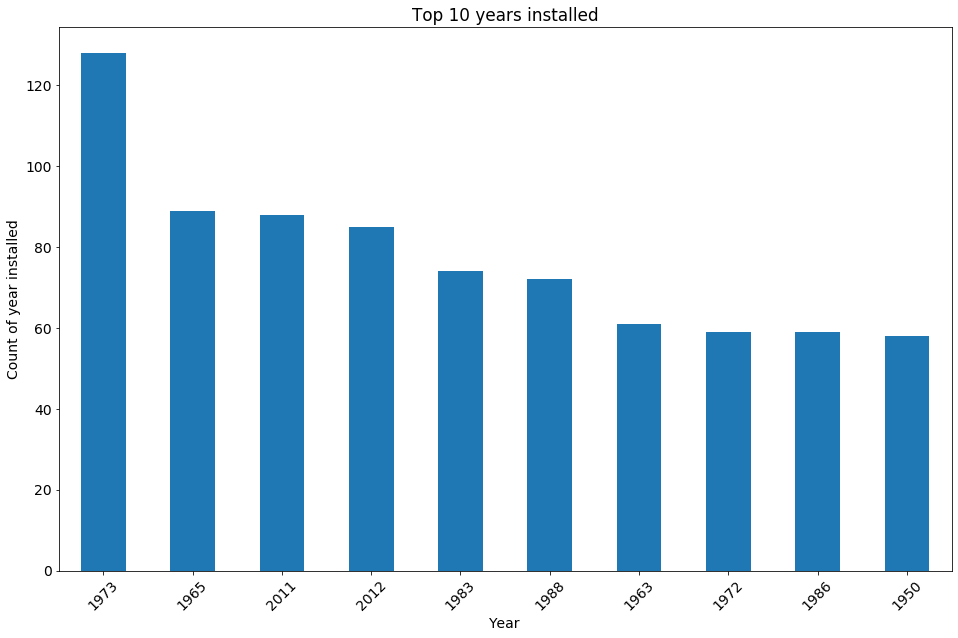

In [42]:
df.inst_year.dropna().astype(int).value_counts().head(10).plot.bar()
plt.xticks(rotation=45)

plt.ylabel('Count of year installed')
plt.xlabel('Year')
plt.title('Top 10 years installed')
plt.show()

In [43]:
# df.root_cause = df.root_cause.str.lower()
# df.root_cause.value_counts()

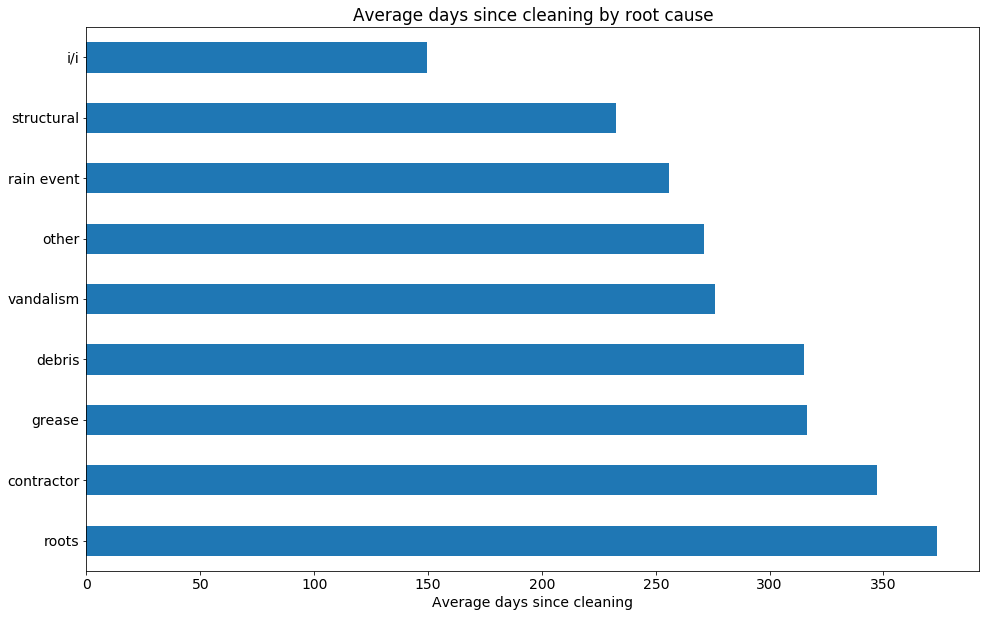

In [44]:
ax = df.groupby('root_cause').days_since_cleaned.mean()\
    .sort_values(ascending=False).dropna().plot.barh()
ax.set_ylabel('')
ax.set_xlabel('Average days since cleaning')
plt.title('Average days since cleaning by root cause')
plt.show()

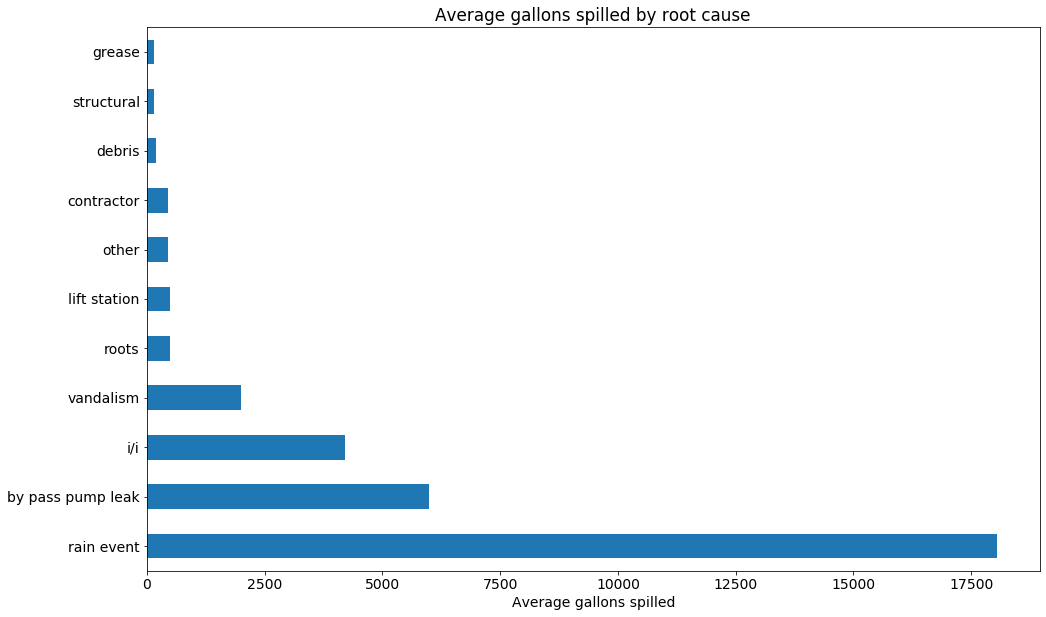

In [45]:
ax = df.groupby('root_cause').total_gal.median()\
    .sort_values(ascending=False).dropna().plot.barh()
ax.set_ylabel('')
ax.set_xlabel('Average gallons spilled')
plt.title('Average gallons spilled by root cause')
plt.show()

In [46]:
# x = pd.cut(df.total_gal, bins=[0,15,50,250,1000, 5000,50000,2000000,
#                                df.total_gal.max()])
# df['total_gal_binned'] = x

In [49]:
type(df['total_gal_binned'].value_counts().index[0])

pandas._libs.interval.Interval

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

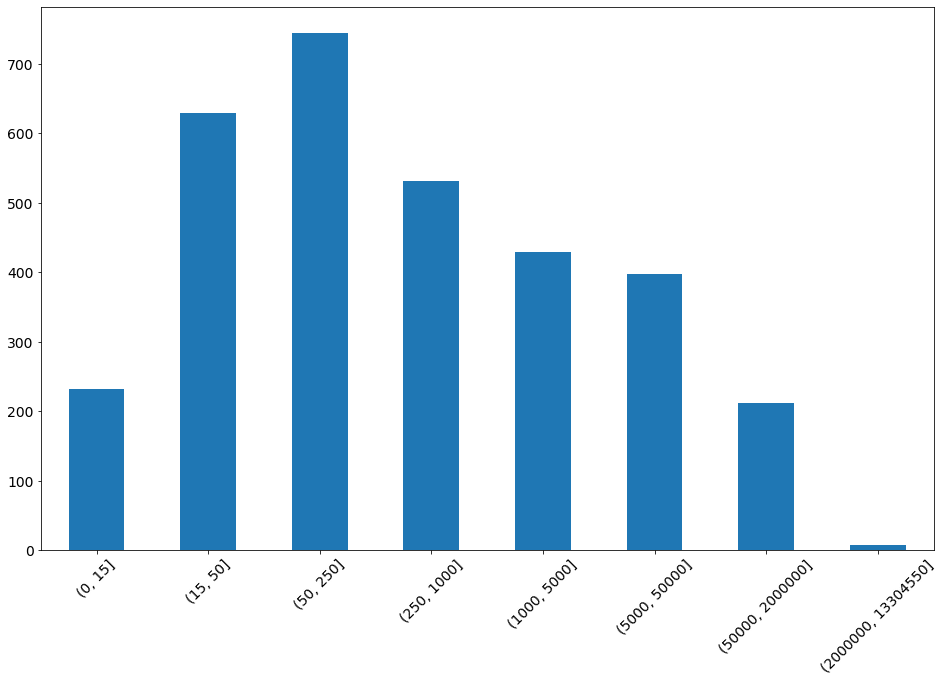

In [54]:
df['total_gal_binned'].value_counts().sort_index().plot.bar()
plt.xticks(rotation=45)

In [56]:
test.days_since_cleaned.dropna()

965     227.0
966     571.0
968     555.0
969     560.0
972     325.0
        ...  
3059     13.0
3075     22.0
3076     16.0
3101     13.0
3106      8.0
Name: days_since_cleaned, Length: 1101, dtype: object

In [57]:
df[df.days_since_cleaned == df.days_since_cleaned.max()]

,sso_id,report_date,spill_address_num,spill_st_name,total_gal,gals_ret,spill_start,spill_stop,hrs,cause,comments,actions,watershed,unit_id,unit_id2,discharge_to,discharge_route,council_district,month,year,week,earz_zone,pipe_diam,pipe_len,pipe_type,inst_year,inches_no,rainfall_last3,spill_address_full,num_spills_recorded,num_spills_24mos,prevspill_24mos,unit_type,asset_type,last_cleaned,response_time,response_dttm,public_notice,root_cause,hrs_2,gal_2,hrs_3,gal_3,days_since_cleaned,total_gal_binned,country_address,location,zip_code
1020,3555,2015-02-23,3,VILLA VERDE,200,0.0,2015-02-23 15:28:00,2015-02-23 16:46:00,1.3,Grease,"Spill ContainedArea Cleaned and DisinfectedFlushed Area with H2O, Unstopped Main,",CLEANED MAIN,DOS RIOS,6169,6157,DRAINAGE CULVERT,None,8.0,2,2015,9,0.0,8.0,400.0,VCP,1974.0,NaN,NaN,3 Villa Verde ( Over Edwards Aquifer Transition Zone ),1,1.0,0,GRAVITY,Sewer Main,2009-11-06 00:00:00,51.0,2015-02-23 16:19:00,False,grease,0.0,0.0,0.0,0.0,1935.0,"(50, 250]","3 Villa Verde ( Over Edwards Aquifer Transition Zone ),SAN ANTONIO,Texas,USA",NaN,None


In [ ]:
df[df.inst_year == df.inst_year.max()].shape

In [ ]:
df.groupby('inst_year').total_gal.median().sort_values(ascending=False)